# %% [markdown]
# # Barra 1D — XPINN (forma forte) com BCs **duras** (hard-BC)
# EDP: d/dx(EA du/dx) = C x, x∈(0,L)
# CC: u(0)=0, u(L)=CL^3/(3EA)
# Interface XPINN: x = L/2 (continuidade de u e EA u')
# Solução analítica **corrigida**: u(x) = (C/EA)*( x^3/6 + L^2 x/6 )


In [1]:
# %% [markdown]
# ## Imports, device e semente

import time
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Device: cpu


In [2]:
# %% [markdown]
# ## Parâmetros físicos e solução analítica (sinal **corrigido**)

EA = 1.0
L  = 5.0
C  = 10.0

def u_analitica(x: torch.Tensor) -> torch.Tensor:
    return (C/EA)*((x**3)/6.0 + (L**2)*x/6.0)

u0 = torch.tensor([[0.0]], device=DEVICE)
uL = torch.tensor([[C*(L**3)/(3.0*EA)]], device=DEVICE)
XI = L/2.0  # interface XPINN


In [3]:
# %% [markdown]
# ## Amostragem (colocação por subdomínios, contorno e interface)

def sample_collocation_xpinn(nf_total, L=L, xi=XI):
    nf1 = nf_total // 2
    nf2 = nf_total - nf1
    x1 = xi * np.random.rand(nf1, 1)               # (0, xi)
    x2 = xi + (L - xi) * np.random.rand(nf2, 1)    # (xi, L)
    x1 = torch.tensor(x1, dtype=torch.float32, device=DEVICE, requires_grad=True)
    x2 = torch.tensor(x2, dtype=torch.float32, device=DEVICE, requires_grad=True)
    return x1, x2

def boundary_points():
    xb0 = torch.tensor([[0.0]], dtype=torch.float32, device=DEVICE)   # sem grad
    xbL = torch.tensor([[L  ]], dtype=torch.float32, device=DEVICE)
    return xb0, u0, xbL, uL

def interface_points(ni=20, xi=XI):
    return torch.full((ni,1), float(xi), dtype=torch.float32, device=DEVICE, requires_grad=True)


In [4]:
# %% [markdown]
# ## Rede MLP (mesma arquitetura em Ω1 e Ω2)

class MLP(nn.Module):
    def __init__(self, in_features=1, out_features=1, hidden_layers=3, hidden_units=20, activation='silu'):
        super().__init__()
        act = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'silu': nn.SiLU(), 'gelu': nn.GELU()}.get(activation, nn.SiLU())
        layers, last = [], in_features
        for _ in range(hidden_layers):
            layers += [nn.Linear(last, hidden_units), act]
            last = hidden_units
        layers += [nn.Linear(last, out_features)]
        self.net = nn.Sequential(*layers)
        self.activation_name = activation
        self.hidden_layers = hidden_layers
        self.hidden_units  = hidden_units
    def forward(self, x):
        if x.dim()==1: x = x.view(-1,1)
        return self.net(x)


In [5]:
# %% [markdown]
# ## Ansatz **hard-BC** (BCs satisfeitas por construção) e normalização

U_SCALE = float(uL.item())

def z1(x):  # (0, XI) -> (-1,1)
    return 2.0*(x-0.0)/(XI-0.0) - 1.0

def z2(x):  # (XI, L) -> (-1,1)
    return 2.0*(x-XI)/(L-XI) - 1.0

# Ω1: u1(0)=0 garantido
def u1_ansatz(m1, x):
    y = m1(z1(x))
    return U_SCALE * (x / XI) * y

# Ω2: u2(L)=uL garantido
def u2_ansatz(m2, x):
    y = m2(z2(x))
    return U_SCALE * (1.0 + ((x - L) / (L - XI)) * y)


In [6]:
# %% [markdown]
# ## Derivadas e resíduos fortes R = EA u'' - C x

def dudx1(m1, x):
    u = u1_ansatz(m1, x)
    return grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

def dudx2(m2, x):
    u = u2_ansatz(m2, x)
    return grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

def d2udx21(m1, x):
    du = dudx1(m1, x)
    return grad(du, x, grad_outputs=torch.ones_like(du), create_graph=True)[0]

def d2udx22(m2, x):
    du = dudx2(m2, x)
    return grad(du, x, grad_outputs=torch.ones_like(du), create_graph=True)[0]

def pde_residual1(m1, x):  # Ω1
    return EA * d2udx21(m1, x) - C * x

def pde_residual2(m2, x):  # Ω2
    return EA * d2udx22(m2, x) - C * x


In [7]:
# %% [markdown]
# ## Perda XPINN (PDE em Ω1 e Ω2 + Interface forte; BC já é "dura")

def loss_components_xpinn(m1, m2, x1f, x2f, xb0, ub0, xbL, ubL, xif, w_bc=1.0, w_if=100.0):
    # PDE
    R1 = pde_residual1(m1, x1f); R2 = pde_residual2(m2, x2f)
    loss_pde = torch.mean(R1**2) + torch.mean(R2**2)

    # BC (com ansatz são ~0; apenas monitor)
    bc0 = torch.mean((u1_ansatz(m1, xb0) - ub0)**2)
    bcL = torch.mean((u2_ansatz(m2, xbL) - ubL)**2)
    loss_bc = bc0 + bcL

    # Interface: continuidade de u e de tração EA u'
    u_jump  = torch.mean((u1_ansatz(m1, xif) - u2_ansatz(m2, xif))**2)
    t_jump  = torch.mean((EA*dudx1(m1, xif) - EA*dudx2(m2, xif))**2)
    loss_if = u_jump + t_jump

    total = loss_pde + w_bc*loss_bc + w_if*loss_if
    loss_bc_report = w_bc*loss_bc + w_if*loss_if  # BC+IF para gráficos
    return total, loss_pde, loss_bc_report


In [8]:
# %% [markdown]
# ## Predição por subdomínios (atenção ao shape)

def predict_piecewise_models(m1, m2, xs):
    mask = (xs.squeeze(-1) <= XI)   # (N,)
    up = torch.empty_like(xs)
    if mask.any():
        up[mask,:]  = u1_ansatz(m1, xs[mask].view(-1,1))
    if (~mask).any():
        up[~mask,:] = u2_ansatz(m2, xs[~mask].view(-1,1))
    return up


In [9]:
# %% [markdown]
# ## Treino em duas etapas: Adam (1000, 1e-4) + LBFGS (15, 1e-4)
# %% [markdown]
# ## Treino em duas etapas: Adam (1000, 1e-4) + LBFGS (15, 1e-4) — **corrigido (sem grad dentro de no_grad)**

def train_xpinn_two_stage(
    epochs_adam=1000, lr_adam=1e-4,
    lbfgs_steps=15, lr_lbfgs=1e-4,
    nf=200, n_if=20, print_every=200,
    hidden_layers=3, hidden_units=20, activation='silu',
    w_bc=1.0, w_if=100.0,
    seed=42
):
    set_seed(seed)

    # Dados
    x1f, x2f = sample_collocation_xpinn(nf_total=nf)
    xb0, ub0, xbL, ubL = boundary_points()
    xif = interface_points(ni=n_if)

    # Modelos
    m1 = MLP(hidden_layers=hidden_layers, hidden_units=hidden_units, activation=activation).to(DEVICE)
    m2 = MLP(hidden_layers=hidden_layers, hidden_units=hidden_units, activation=activation).to(DEVICE)
    m1.train(); m2.train()

    hist_total, hist_pde, hist_bc = [], [], []
    t0 = time.perf_counter()

    # --- Adam ---
    opt_adam = torch.optim.Adam(list(m1.parameters())+list(m2.parameters()), lr=lr_adam)
    for ep in range(1, epochs_adam+1):
        opt_adam.zero_grad(set_to_none=True)
        T, Lp, Lb = loss_components_xpinn(m1, m2, x1f, x2f, xb0, ub0, xbL, ubL, xif, w_bc=w_bc, w_if=w_if)
        T.backward()
        torch.nn.utils.clip_grad_norm_(list(m1.parameters())+list(m2.parameters()), max_norm=1.0)
        opt_adam.step()

        hist_total.append(T.detach().item())
        hist_pde.append(Lp.detach().item())
        hist_bc.append(Lb.detach().item())

        if (ep % print_every)==0 or ep==1 or ep==epochs_adam:
            print(f"[Adam ] ep {ep:4d}/{epochs_adam} | total={hist_total[-1]:.3e} | pde={hist_pde[-1]:.3e} | bc+if={hist_bc[-1]:.3e}")

    # --- LBFGS (refino) ---
    opt_lbfgs = torch.optim.LBFGS(list(m1.parameters())+list(m2.parameters()),
                                  lr=lr_lbfgs, max_iter=20, history_size=50, line_search_fn='strong_wolfe')
    def closure():
        opt_lbfgs.zero_grad(set_to_none=True)
        with torch.enable_grad():
            T_c, _, _ = loss_components_xpinn(m1, m2, x1f, x2f, xb0, ub0, xbL, ubL, xif, w_bc=w_bc, w_if=w_if)
        T_c.backward()
        return T_c

    for step in range(1, lbfgs_steps+1):
        opt_lbfgs.step(closure)
        T, Lp, Lb = loss_components_xpinn(m1, m2, x1f, x2f, xb0, ub0, xbL, ubL, xif, w_bc=w_bc, w_if=w_if)
        hist_total.append(T.detach().item())
        hist_pde.append(Lp.detach().item())
        hist_bc.append(Lb.detach().item())
        print(f"[LBFGS] step {step:3d}/{lbfgs_steps} | total={hist_total[-1]:.3e} | pde={hist_pde[-1]:.3e} | bc+if={hist_bc[-1]:.3e}")

    train_time = time.perf_counter() - t0

    # --------- Avaliação ---------
    # Erro L2 relativo (não precisa de grad)
    with torch.no_grad():
        xs = torch.linspace(0.0, L, 500, device=DEVICE).view(-1,1)
        ua = u_analitica(xs)
        up = predict_piecewise_models(m1, m2, xs)
        rel_L2 = (torch.linalg.norm(up-ua)/torch.linalg.norm(ua)).item()
        # BCs (apenas forward)
        e0 = (u1_ansatz(m1, xb0) - ub0).abs().item()
        eL = (u2_ansatz(m2, xbL) - ubL).abs().item()

    # Interface: precisa de derivadas -> habilite grad aqui
    with torch.enable_grad():
        xif_eval = interface_points(ni=50)  # requires_grad=True
        uj = (u1_ansatz(m1, xif_eval) - u2_ansatz(m2, xif_eval))
        tj = (EA*dudx1(m1, xif_eval) - EA*dudx2(m2, xif_eval))
        uj = uj.abs().mean().item()
        tj = tj.abs().mean().item()

    return {
        "model1": m1, "model2": m2,
        "hist_total": hist_total, "hist_pde": hist_pde, "hist_bc": hist_bc,
        "train_time_s": train_time, "rel_L2": rel_L2,
        "bc_err_0": e0, "bc_err_L": eL, "if_u_jump": uj, "if_t_jump": tj,
        "nf": nf, "nf_if": n_if, "hidden_layers": hidden_layers, "hidden_units": hidden_units, "activation": activation,
        "epochs_adam": epochs_adam, "lr_adam": lr_adam, "lbfgs_steps": lbfgs_steps, "lr_lbfgs": lr_lbfgs,
        "w_bc": w_bc, "w_if": w_if
    }


In [10]:
# %% [markdown]
# ## Executar com NF=200, 20 pontos de interface, Adam(1000,1e-4)+LBFGS(15,1e-4)

NF      = 200
NF_IF   = 20
HLAYERS = 3
HUNITS  = 20
ACTIV   = 'silu'   # recomendado

EPOCHS_ADAM = 1000
LR_ADAM     = 1e-4
LBFGS_STEPS = 15
LR_LBFGS    = 1e-4

res = train_xpinn_two_stage(
    epochs_adam=EPOCHS_ADAM, lr_adam=LR_ADAM,
    lbfgs_steps=LBFGS_STEPS, lr_lbfgs=LR_LBFGS,
    nf=NF, n_if=NF_IF, print_every=200,
    hidden_layers=HLAYERS, hidden_units=HUNITS, activation=ACTIV,
    w_bc=1.0, w_if=100.0,  # pesos (interface mais forte)
    seed=42
)

print(f"\nTempo total: {res['train_time_s']:.2f} s | Erro L2 rel: {res['rel_L2']:.3e}")
print(f"BC: |u(0)-0|={res['bc_err_0']:.2e}  |  |u(L)-uL|={res['bc_err_L']:.2e}  |  Interface: <|Δu|>={res['if_u_jump']:.2e}, <|Δ(EA u')|>={res['if_t_jump']:.2e}")


[Adam ] ep    1/1000 | total=1.542e+07 | pde=1.787e+03 | bc+if=1.542e+07
[Adam ] ep  200/1000 | total=5.802e+06 | pde=2.772e+03 | bc+if=5.800e+06
[Adam ] ep  400/1000 | total=8.460e+03 | pde=8.365e+03 | bc+if=9.463e+01
[Adam ] ep  600/1000 | total=3.182e+03 | pde=3.181e+03 | bc+if=1.394e+00
[Adam ] ep  800/1000 | total=5.913e+02 | pde=5.895e+02 | bc+if=1.875e+00
[Adam ] ep 1000/1000 | total=1.546e+02 | pde=1.530e+02 | bc+if=1.605e+00
[LBFGS] step   1/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   2/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   3/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   4/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   5/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   6/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   7/15 | total=1.527e+02 | pde=1.526e+02 | bc+if=1.529e-01
[LBFGS] step   8/15 | total=1.527e+02 | pde=1.526e+02 | bc

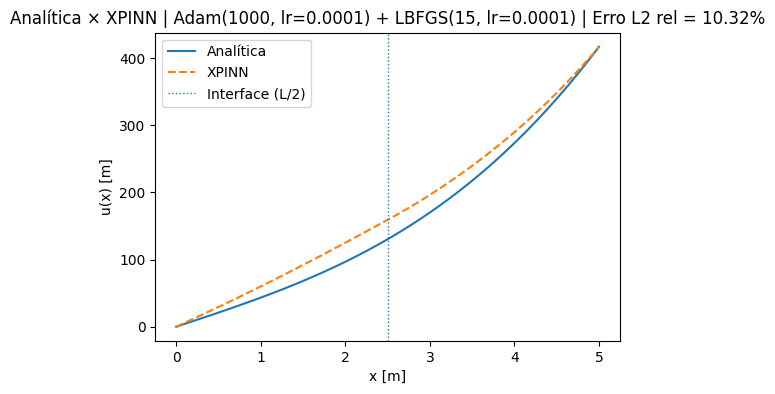

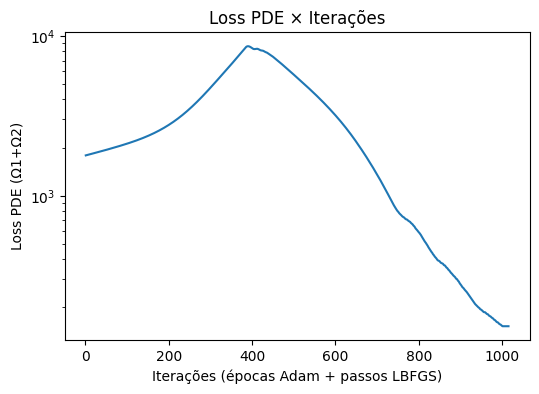

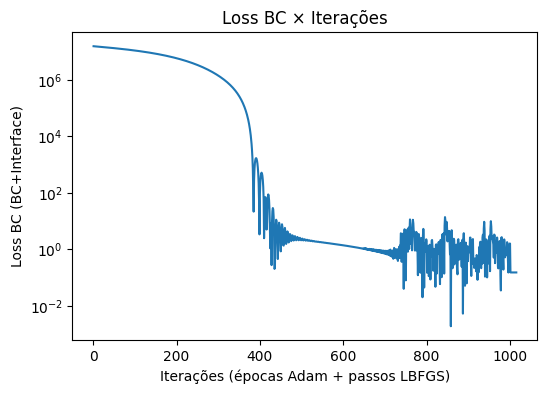

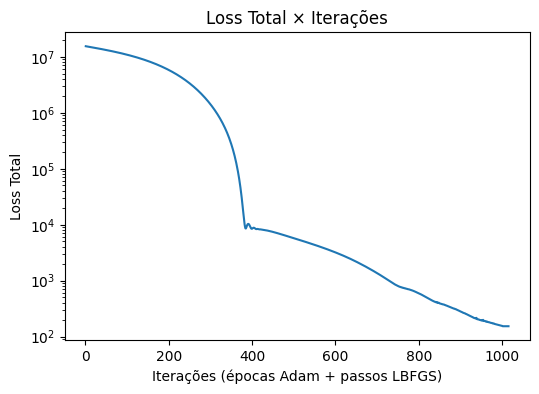

In [11]:
# %% [markdown]
# ## Gráficos — Analítica × XPINN (erro %) e perdas individuais

m1, m2 = res["model1"], res["model2"]
m1.eval(); m2.eval()

with torch.no_grad():
    xs = torch.linspace(0.0, L, 400, device=DEVICE).view(-1,1)
    xp = xs.cpu().numpy().squeeze()
    up = predict_piecewise_models(m1, m2, xs).cpu().numpy().squeeze()
    ua = u_analitica(xs).cpu().numpy().squeeze()

rel_l2_percent = 100.0 * res["rel_L2"]

plt.figure(figsize=(6,4))
plt.plot(xp, ua, label="Analítica")
plt.plot(xp, up, linestyle="--", label="XPINN")
plt.axvline(XI, ls=":", lw=1, label="Interface (L/2)")
plt.xlabel("x [m]"); plt.ylabel("u(x) [m]")
plt.title(f"Analítica × XPINN | Adam({res['epochs_adam']}, lr={res['lr_adam']}) + "
          f"LBFGS({res['lbfgs_steps']}, lr={res['lr_lbfgs']}) | Erro L2 rel = {rel_l2_percent:.2f}%")
plt.legend(); plt.show()

# perdas individuais (PDE, BC+IF, Total)
t = np.arange(1, len(res["hist_total"])+1)

plt.figure(figsize=(6,4))
plt.semilogy(t, res["hist_pde"])
plt.xlabel("Iterações (épocas Adam + passos LBFGS)"); plt.ylabel("Loss PDE (Ω1+Ω2)")
plt.title("Loss PDE × Iterações")
plt.show()

plt.figure(figsize=(6,4))
plt.semilogy(t, res["hist_bc"])
plt.xlabel("Iterações (épocas Adam + passos LBFGS)"); plt.ylabel("Loss BC (BC+Interface)")
plt.title("Loss BC × Iterações")
plt.show()

plt.figure(figsize=(6,4))
plt.semilogy(t, res["hist_total"])
plt.xlabel("Iterações (épocas Adam + passos LBFGS)"); plt.ylabel("Loss Total")
plt.title("Loss Total × Iterações")
plt.show()


In [12]:
# %% [markdown]
# ## Informações do melhor modelo

print(
    "Estrutura da rede (Ω1):\n", res["model1"],
    "\n\nEstrutura da rede (Ω2):\n", res["model2"],
    f"\n\nNF total: {res['nf']}  |  Pontos de interface: {res['nf_if']}"
    f"\nAtivação: {res['activation']}"
    f"\nTreino: Adam({res['epochs_adam']}, lr={res['lr_adam']})  +  LBFGS({res['lbfgs_steps']}, lr={res['lr_lbfgs']})"
    f"\nPesos: w_bc={res['w_bc']}  |  w_if={res['w_if']}"
    f"\nErro L2 relativo final: {res['rel_L2']:.3e}"
)


Estrutura da rede (Ω1):
 MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): SiLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SiLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): SiLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
) 

Estrutura da rede (Ω2):
 MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): SiLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SiLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): SiLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
) 

NF total: 200  |  Pontos de interface: 20
Ativação: silu
Treino: Adam(1000, lr=0.0001)  +  LBFGS(15, lr=0.0001)
Pesos: w_bc=1.0  |  w_if=100.0
Erro L2 relativo final: 1.032e-01
